# Numerical errors in Muskingum-Cunge routing when C > 1
The Courant number, C, is an important diagnostic metric for river routing models, defined as the ratio of the kinematic wave celerity to numerical celerity (the grid ratio Δx/Δt). According to [Ponce](http://ponce.sdsu.edu/muskingum_cunge_amplitude_and_phase_portraits_with_online_computation.html), the Muskingum-Cunge routing method is a reasonable representation of the physical prototype if C < 1. When C > 1, insidious numerical errors change in the timing and magnitude of simulated wave propagation. These errors are "insidious" because they easily go unnoticed and do not manifest in easily identified spurious oscillations. 

This notebook illustrates the impacts of Courant values on the timing and shape of M-C simulated flood waves. A simple numerical experiment simulates the downstream propagation of Gaussian-shaped wave along a 20km channel of uniform geometry and roughness. We vary C between 5 simulations by changing the timestep, while leaving all other parameters constant. Experiment results show that when C > 1, the timing of wave propagation is delayed, peak flows are lowered, and waves are more temporally diffusive. Therefore, we suggest that a higher level of attention be paid to the value of Courant numbers across time/space domains of network-scale simulations. 

To facilitate our suggestion, we propose slight adjustments to the M-C FORTRAN module in WRF Hydro to return a handful of important diagnostic metrics: kinematic celerity, courant number, and the M-C X parameter. You can view the adjusted version of the M-C FOTRAN module [here](https://github.com/awlostowski-noaa/t-route/blob/courant/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/courant_dev/MCsingleSegStime_f2py_NOLOOP-anw.f90), which is called in the notebook below. 

In [1]:
import sys
import os
import subprocess
import csv
import numpy as np
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

try:
    import google.colab

    ENV_IS_CL = True
    root = r"/content/t-route"
    subprocess.run(["git", 
                    "clone", 
                    "-b",
                    "courant",
                    "https://github.com/awlostowski-noaa/t-route.git"])
    
    
except:
    root = os.path.dirname(os.path.abspath(""))

# development directory contains modified MC FORTRAN module with newly develope Courant subroutine
dev_directory = os.path.join(root,"src","fortran_routing","mc_pylink_v00","MC_singleSeg_singleTS","courant_dev")
sys.path.append(dev_directory)

# development directory contains unmodified, or "base", MC FORTRAN module
base_directory = os.path.join(root,"src","fortran_routing","mc_pylink_v00","MC_singleSeg_singleTS")
sys.path.append(base_directory)


## Compile the M-C FORTRAN module via f2py and import
NOTE: [This module](https://github.com/awlostowski-noaa/t-route/blob/courant/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/courant_dev/MCsingleSegStime_f2py_NOLOOP-anw.f90) has been updated to return kinematic celerity, the courant number, and the M-C X parameter.

In [2]:
cmd = subprocess.run(
    ["cp", 
     os.path.join(base_directory, "varPrecision.f90"), 
     os.path.join(dev_directory,  "varPrecision.f90")],
    cwd=dev_directory,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

# Compile MC module
f2py_call = []
f2py_call.append(r"f2py3")
f2py_call.append(r"-c")
f2py_call.append(r"varPrecision.f90")
f2py_call.append(r"MCsingleSegStime_f2py_NOLOOP-anw.f90")
f2py_call.append(r"-m")
f2py_call.append(r"mc_sseg_stime_anw")

subprocess.run(
    f2py_call,
    cwd=dev_directory,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)

# import Python shared object 
try:
    # import MC subroutine from shared object
    from mc_sseg_stime_anw import muskingcunge_module as mc_anw

except:
    print("ERROR: Couldn't find mc_sseg_stime shared_anw object. There may be a problem with the f2py compile process.")
    

## Reach simulation kernel
- Simulate wave propagation along a reach by stepping through time and space, calling the M-C module at each time/space step.
- Store model results in [distance x time] DataFrames
- A Gusssian-shaped lateral inflow forcing is handed to the first segment of the reach. 

In [3]:
def reach_sim(dt,dx, rchlen, duration, params, q0, h0, t_pk, scale, pk_scale):
    
    """
    reach_sim

    Args:
        dt (float): timestep of simulation, seconds
        dx (float): uniform segment length of the domain, meters
        rchlen (float): reach length, meters. NOTE: if rchlen is not evenly divisible by dx, the reach lengh will be reduced
        duration (float): simulation duration, seconds, NOTE: if duration is not evenly divisible by dt, the total simulation time will be reduced
        params (dict): channel gemoetry and roughness parameters
            bw: bottom, meters
            tw: top width, meters
            twcc: top width of the compund channel. meters
            n: Manning's roughness coeff of the main channel, s/[m^(1/3)]
            ncc: Manning's roughness coeff of the comound channel, s/[m^(1/3)]
            cs: channel side slope, m/m
            s0: channel (logitudinal, along river) bottom slope, m/m
        q0 (float): initial flow in all segments of the reach, m3/s
        h0 (float): initial depth in all segments of the reach, m
        t_pk (float): time of qlateral flow peak, seconds. NOTE: must be less than simulation duration
        scale (float): scale parameter of the Guassian shaped qlateral series - this controls the temporal width of the qlateral wave
        pk_scale (float): multiplier determining the magnitude of the qlateral series peak flow - q_peak = pk_scale * q0
        
    Notes:
        
    """
    
    # build time/space domain
    segments = range(0,int(rchlen/dx))
    tsteps = range(0,int(duration/dt))

    # initialize matrices
    flow = pd.DataFrame(index = segments, columns = tsteps)
    depth = pd.DataFrame(index = segments, columns = tsteps)
    velocity = pd.DataFrame(index = segments, columns = tsteps)
    celerity = pd.DataFrame(index = segments, columns = tsteps)
    courant = pd.DataFrame(index = segments, columns = tsteps)
    x_param = pd.DataFrame(index = segments, columns = tsteps)
    ql = pd.DataFrame(0, index = segments, columns = tsteps)

    # initialize flow and depth
    flow.loc[:,0] = q0
    depth.loc[:,0] = h0
    velocity.loc[:,0] = 0

    # build lateral inflow data
    q_pk = pk_scale*q0
    x = np.linspace(0,duration, int(duration/dt))
    y = norm.pdf(x,t_pk,scale)
    y_scale = y * q_pk/max(y) + q0
    ql.iloc[0,:] = y_scale

    # execute simulation, stepping through time and space
    for t in tsteps[1:]:

        for x in segments:

            # qup - flow from the upstream segment in the previous timestep
            if x == 0:
                qup = 0
            else:
                qup = flow.iloc[x-1,t-1]

            # quc - flow from the upstream segment, current timestep
            if x == 0:
                quc = 0
            else:
                quc = flow.iloc[x-1,t]

            # qdp - flow in this segment, previous timestep
            qdp = flow.iloc[x,t-1]

            # MC compute kernel
            q, v, d, ck, cn, X = mc_anw.muskingcungenwm(
                        dt,
                        qup,
                        quc,
                        qdp,
                        ql.loc[x,t],
                        dx,
                        params["bw"],
                        params["tw"],
                        params["twcc"],
                        params["n"],
                        params["ncc"],
                        params["cs"],
                        params["s0"],
                        0, # velocity - is an argument, but not used in M-C module - so pass zero
                        depth.iloc[x,t-1]
                    )

            # update matrices
            flow.loc[x,t] = q
            depth.loc[x,t] = d
            velocity.loc[x,t] = v
            celerity.loc[x,t] = ck
            courant.loc[x,t] = cn
            x_param.loc[x,t] = X

    return flow, depth, velocity, celerity, courant, x_param, ql
        

## A sensitivity analysis of wave timing & magnitude to C
- call the simulation function above for different timestep sizes. 
- Reach length, simulation time, initial conditions,  forcings, and channel geometry are held constant. 
- Plot stream flow from of the downstream-most segment of the reach for each simulation. Observe how wave timing and shape changes as a function of dt.

starting dt sensitivity simulations, these will take a while, especiall for small dt
executing simulation for dt = 30 seconds...
Peak time =  [6.43333333]  hours
executing simulation for dt = 60 seconds...
Peak time =  [6.43333333]  hours
executing simulation for dt = 120 seconds...
Peak time =  [6.4]  hours
executing simulation for dt = 300 seconds...
Peak time =  [6.75]  hours
executing simulation for dt = 600 seconds...
Peak time =  [7.5]  hours


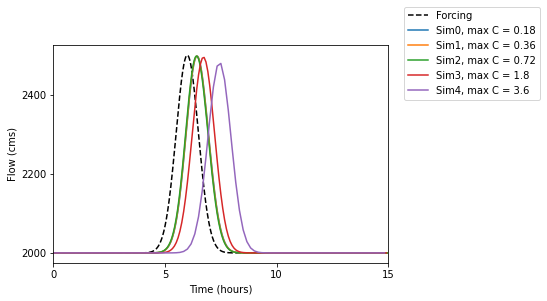

In [4]:
# channel geometry and roughness parameters
params = {}
params["bw"] = 50.0
params["tw"] = 100.0
params["twcc"] = 500.60
params["n"] = 0.02800000086426735
params["ncc"] = 0.03136000037193298
params["cs"] = 0.42
params["s0"] = 0.007999999690800905

# simulation parameters
dt_array = [30,60,120,300,600]
duration = 15 * (60*60)
dx = 2000
rchlen = 20000
q0 = 2000
h0 = 2.78
t_pk = 6 * (60*60)
scale = 0.5 * (60*60)
pk_scale = 0.25

print("starting dt sensitivity simulations, these will take a while, especiall for small dt")
for i, dt in enumerate(dt_array):
    
    print("executing simulation for dt =", dt, "seconds...")
    
    # run simulation
    flow, depth, velocity, celerity, courant, x_param, ql = reach_sim(dt ,dx, rchlen, duration, params, q0, h0, t_pk, scale, pk_scale)
    
    time = (flow.columns.values * dt)/(60*60) # hours
    q = flow.loc[flow.index.max(),:]
    
    if i == 0:
        q_lateral = ql.loc[ql.index.min(),:]
        plt.plot(time, q_lateral, '--',color = 'k',label = "Forcing")
    
    plt.plot(time,q, label = "Sim" + str(i) + ", max C = " + str(round(courant.max().max(),2)))
    
    m = max(q)
    print("Peak time = ",time[[k for k, j in enumerate(q) if j == m]], " hours")
    
plt.xlim([0,15])
plt.ylabel("Flow (cms)")
plt.xlabel("Time (hours)")
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.2), fancybox=True, shadow=False)
plt.rcParams.update({'font.size': 22})
fig = plt.gcf()
fig.patch.set_facecolor('white')
plt.show()    


## Results
1. Simulations 0, 1, and 2 are visually indistinguishable and plot on top of one another. These simulations have a common peak flow timing of 6.43 hours. 
2. Simulation 3 and 4 have maximum Courant numbers greater that 1 and have peak flow timings of 6.75 and 7.5 hours, respectively. Wave attenuation increases with the departure of C over 1 
3. Similarly, simulations 3 and 4 have lower peak flows and appear more diffusive compared to simulations with C < 1. 